In [41]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import datetime 
import xlrd
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OneHotEncoder


In [42]:
# Set file path (replace with your actual path
file_path = "C:/Users/Suyash/OneDrive/Desktop/Quantium_forage"
file_path


'C:/Users/Suyash/OneDrive/Desktop/Quantium_forage'

In [43]:
# Read data files
transaction_data = pd.read_excel("QVI_transaction_data.xlsx")
customer_data = pd.read_csv("QVI_purchase_behaviour.csv")

In [44]:
# Examining the transaction data - view a summary of the table
trans_df = transaction_data.copy() # Keep a copy for a quick reset 
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [45]:
# Change date from xls integer dates to date format in customer data
trans_df['DATE'] = pd.to_datetime(trans_df['DATE'], unit='D', origin='1899-12-30')
print(trans_df['DATE'].dtype) # check format of replacement date column 

datetime64[ns]


In [46]:
trans_df['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [47]:
prod_name = trans_df['PROD_NAME'].str.replace(r'[0-9]+[gG]','')
prod_name = prod_name.str.replace(r'&','')

In [48]:
word_counts = pd.Series(' '.join(prod_name).split()).value_counts()

with pd.option_context('display.max_rows',None):
    display(word_counts)

175g                  60561
Chips                 49770
150g                  41633
Kettle                41288
Smiths                28860
Salt                  27976
Cheese                27890
134g                  25102
Pringles              25102
Doritos               24962
Crinkle               23960
110g                  22387
Corn                  22063
Original              21560
Cut                   20754
Chip                  18645
170g                  18502
Salsa                 18094
Chicken               15407
165g                  15297
Sea                   14145
Thins                 14075
Chilli                13895
Sour                  13882
Crisps                12607
330g                  12540
Vinegar               12402
300g                  12041
RRD                   11894
Infuzions             11057
Supreme               10963
WW                    10320
Popd                   9693
Cobs                   9693
Tortilla               9580
Tostitos            

In [49]:
trans_df = trans_df[trans_df['PROD_NAME'].str.contains("Salsa") == False]
trans_df.shape

(246742, 8)

In [50]:
trans_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


In [51]:
trans_df.isnull().values.any()

False

In [52]:
trans_df.loc[trans_df['PROD_QTY']==200.0]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [53]:
trans_df.loc[trans_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [54]:
trans_df = trans_df[trans_df['LYLTY_CARD_NBR'] != 226000]
trans_df.shape

(246740, 8)

In [55]:
trans_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897


In [56]:
# Count transactions by date to see if there are any missing days 
count = trans_df.groupby(trans_df['DATE'].dt.date).size().reset_index(name = 'COUNT')
count.shape

(364, 2)

In [57]:
trans_df.sort_values(by='DATE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
9161,2018-07-01,88,88140,86914,25,Pringles SourCream Onion 134g,2,7.4
155442,2018-07-01,60,60276,57330,3,Kettle Sensations Camembert & Fig 150g,2,9.2
181349,2018-07-01,199,199014,197623,104,Infuzions Thai SweetChili PotatoMix 110g,2,7.6
229948,2018-07-01,35,35052,31630,11,RRD Pc Sea Salt 165g,1,3.0
104647,2018-07-01,72,72104,71038,20,Doritos Cheese Supreme 330g,2,11.4
...,...,...,...,...,...,...,...,...
10254,2019-06-30,112,112141,114611,98,NCC Sour Cream & Garden Chives 175g,2,6.0
113220,2019-06-30,207,207155,205513,99,Pringles Sthrn FriedChicken 134g,2,7.4
229182,2019-06-30,10,10140,9882,12,Natural Chip Co Tmato Hrb&Spce 175g,2,6.0
229015,2019-06-30,6,6258,6047,29,French Fries Potato Chips 175g,1,3.0


In [58]:
date_counts = trans_df.groupby('DATE').size()


pd.date_range(start ='2018-07-01' , end='2019-06-30').difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [59]:
trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float),True)
trans_df.sort_values(by = "PACK_SIZE")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Suyash\AppData\Local\Temp\ipykernel_4060\2531183476.py:1: SyntaxWarning: invalid escape sequence '\d'
  trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float),True)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
40783,2018-09-25,97,97067,96696,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42461,2019-05-05,110,110030,111890,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
176183,2018-12-30,82,82183,81660,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
227309,2018-12-03,236,236091,239098,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42418,2018-11-05,109,109217,111470,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
...,...,...,...,...,...,...,...,...,...
192034,2019-03-12,100,100121,99145,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
255797,2019-01-19,235,235098,238018,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
233814,2019-01-24,151,151102,149810,4,Dorito Corn Chp Supreme 380g,1,6.5,380.0
131573,2018-07-09,213,213087,212416,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0


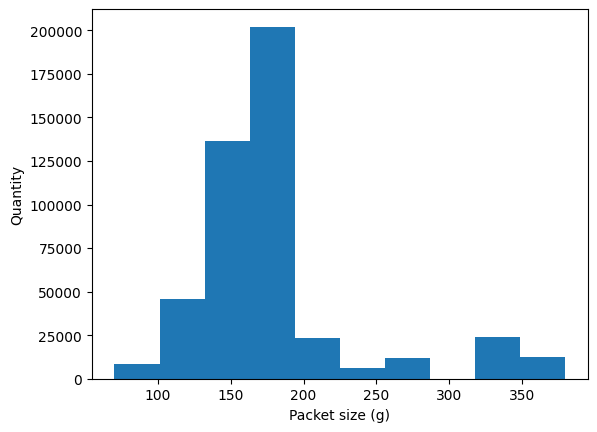

In [60]:
plt.hist(trans_df['PACK_SIZE'], weights=trans_df['PROD_QTY']);
plt.xlabel('Packet size (g)');

plt.ylabel('Quantity');

In [61]:
trans_df.insert(9, "BRAND_NAME",trans_df['PROD_NAME'].str.split().str.get(0), True)
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos


In [62]:
trans_df["BRAND_NAME"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [63]:
# Create a function to identify the string replacements needed.
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 

# Then apply the function to clean the brand names
trans_df["BRAND_NAME"] = trans_df.apply(lambda line: replace_brandname(line), axis=1)

# Check that there are no duplicate brands 
trans_df["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [64]:
cust_df = customer_data.copy()
cust_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [65]:
cust_df = cust_df.rename(columns={'PREMIUM_CUSTOMER': 'MEMBER_TYPE'})

In [66]:
cust_df.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [67]:
cust_df["MEMBER_TYPE"].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [68]:
cust_df["LIFESTAGE"].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [69]:
full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
full_df = full_df.reset_index()
full_df = full_df.sort_values(by='DATE').reset_index(drop=True)
full_df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,MEMBER_TYPE
0,21037,2018-07-01,21,17576,62,Pringles Mystery Flavour 134g,2,7.4,134.0,Pringles,RETIREES,Mainstream
1,25040,2018-07-01,25,21704,87,Infuzions BBQ Rib Prawn Crackers 110g,2,7.6,110.0,Infuzions,OLDER FAMILIES,Budget
2,59236,2018-07-01,59,55555,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos,OLDER SINGLES/COUPLES,Budget
3,271083,2018-07-01,271,268688,97,RRD Salt & Vinegar 165g,2,6.0,165.0,Red Rock Deli,YOUNG FAMILIES,Budget
4,65015,2018-07-01,65,61737,17,Kettle Sensations BBQ&Maple 150g,2,9.2,150.0,Kettle,YOUNG FAMILIES,Premium
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,48160,2019-06-30,48,44051,11,RRD Pc Sea Salt 165g,2,6.0,165.0,Red Rock Deli,RETIREES,Mainstream
246736,175371,2019-06-30,175,176890,40,Thins Chips Seasonedchicken 175g,2,6.6,175.0,Thins,OLDER SINGLES/COUPLES,Budget
246737,203312,2019-06-30,203,203610,68,Pringles Chicken Salt Crips 134g,2,7.4,134.0,Pringles,MIDAGE SINGLES/COUPLES,Mainstream
246738,222003,2019-06-30,222,221524,17,Kettle Sensations BBQ&Maple 150g,2,9.2,150.0,Kettle,RETIREES,Mainstream


In [70]:
full_df.isnull().values.any()

False

In [71]:
full_df.to_csv('QVI_fulldata.csv')

Data Analysis on Customer Segment:

In [72]:
total_sales_cust = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'], as_index = False)['TOT_SALES'].agg(['sum'])
total_sales_cust = total_sales_cust.rename(columns={'sum': 'sum_tot_sales'})
total_sales_cust.sort_values(by = "sum_tot_sales", ascending = False)

,LIFESTAGE,MEMBER_TYPE,sum_tot_sales
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


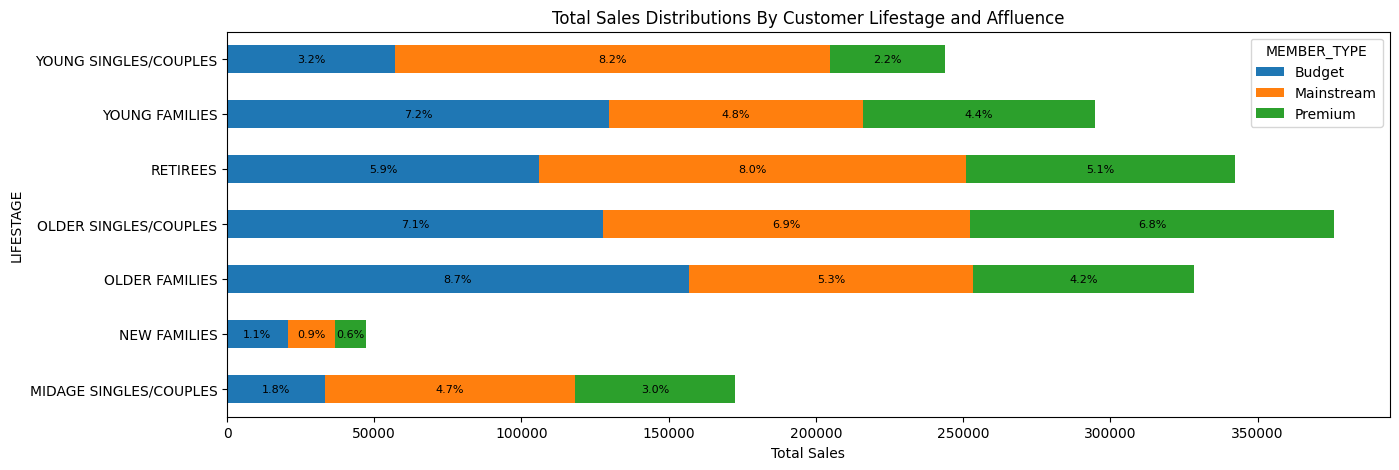

In [73]:
# Get the total sales 
total_sales = full_df['TOT_SALES'].agg(['sum'])['sum']
# Plot a breakdown of the total sales by lifestage and member type
total_sales_breakdown = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'], as_index = True)['TOT_SALES'].agg(['sum', 'mean']).unstack('MEMBER_TYPE').fillna(0)
ax = total_sales_breakdown['sum'].plot(kind='barh', stacked=True, figsize=(15, 5))

# Add percentages of the summed total sales as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    label = width / total_sales * 100
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(label):.1f}%' 
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("Total Sales")
ax.set_title('Total Sales Distributions By Customer Lifestage and Affluence')
plt.show()

In [74]:
len(cust_df['LYLTY_CARD_NBR'].unique()) == cust_df.shape[0]

True

In [75]:
# Check if all customers made chip purchases. 
len(cust_df['LYLTY_CARD_NBR'].unique()) == len(full_df['LYLTY_CARD_NBR'].unique())

False

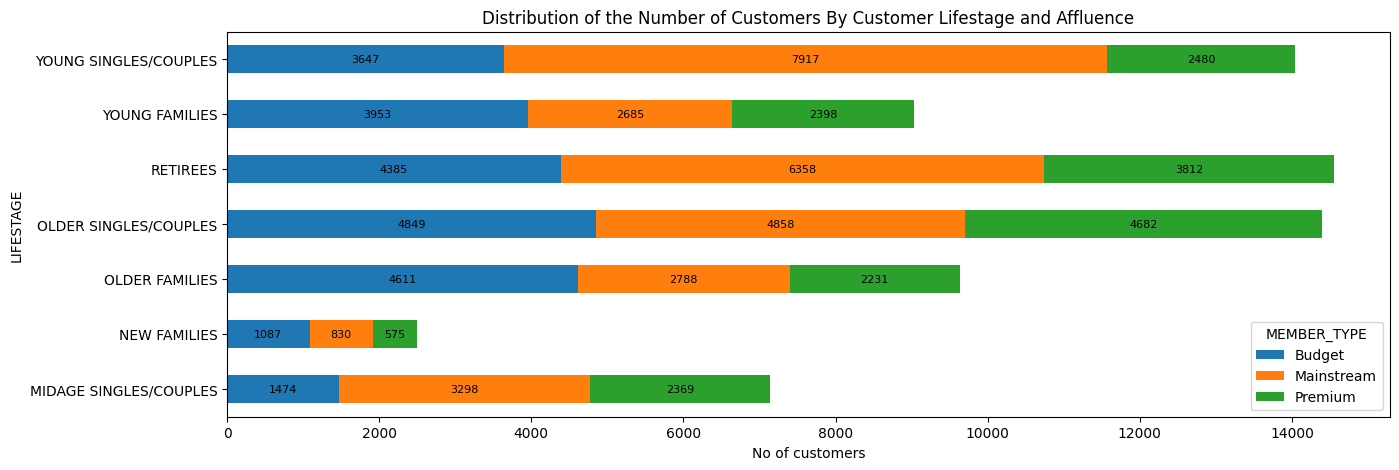

In [76]:
# Plot the numbers of customers in each segment by counting the unique LYLTY_CARD_NBR entries
sum_customers= full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].agg('nunique').unstack('MEMBER_TYPE').fillna(0)
ax = sum_customers.plot(kind='barh', stacked=True, figsize=(15, 5))

# Add customer numbers as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(width):.0f}'
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("No of customers")
ax.set_title('Distribution of the Number of Customers By Customer Lifestage and Affluence')
plt.show()

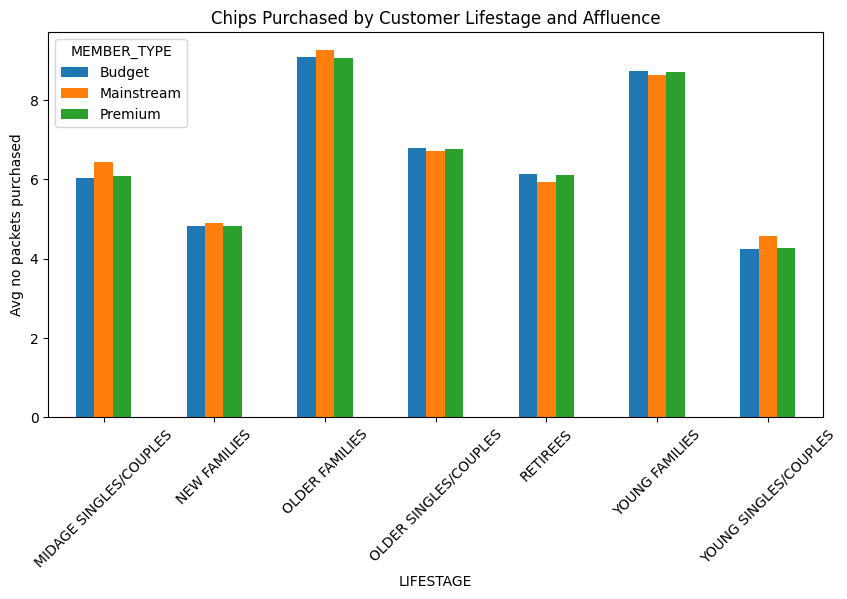

In [77]:
# Plot the average no of chip packets bought per customer by LIFESTAGE and MEMBER_TYPE.
no_packets_data = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['PROD_QTY'].sum()/full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].nunique(0)
ax = no_packets_data.unstack('MEMBER_TYPE').fillna(0).plot.bar(stacked = False,figsize=(10, 5))
ax.set_ylabel("Avg no packets purchased")
ax.set_title('Chips Purchased by Customer Lifestage and Affluence')
plt.xticks(rotation=45)
plt.show()

In [78]:
# Create a column for the unit price of chips purchased per transaction 
full_df['UNIT_PRICE'] = full_df['TOT_SALES']/full_df['PROD_QTY']

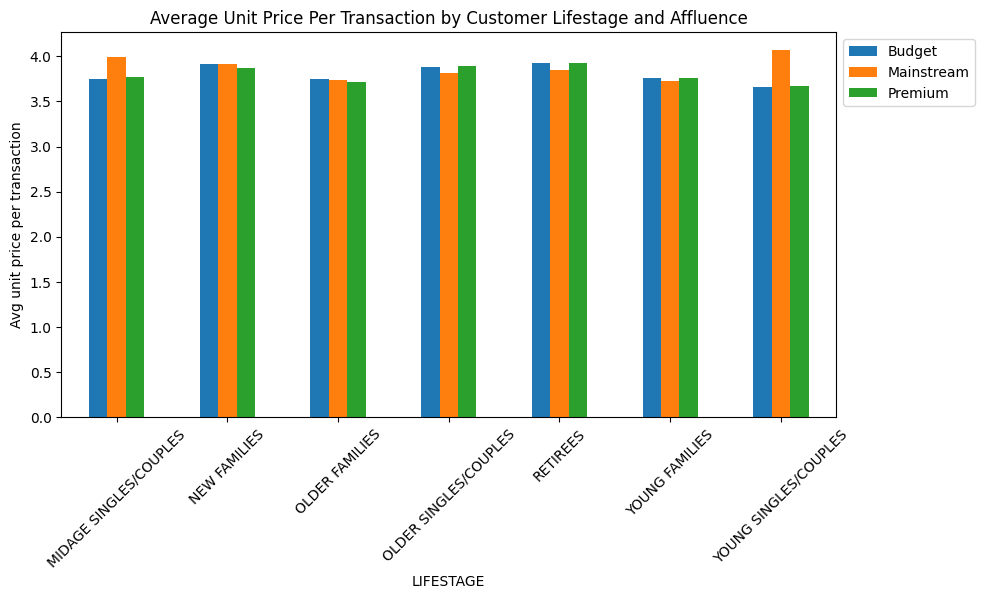

In [80]:
# Plot the distribution of the average unit price per transaction by LIFESTAGE and MEMBER_TYPE.
avg_priceperunit = full_df.groupby(['LIFESTAGE', 'MEMBER_TYPE'], as_index = True)['UNIT_PRICE'].agg(['mean']).unstack('MEMBER_TYPE').fillna(0)
ax = avg_priceperunit['mean'].plot.bar(stacked=False, figsize=(10, 5))
ax.set_ylabel("Avg unit price per transaction")
ax.set_title('Average Unit Price Per Transaction by Customer Lifestage and Affluence')
plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=45)
plt.show()

In [81]:
# Check the difference in the average price unit between the mainstream and premium/budget groups for young/midage singles/couples
from scipy.stats import ttest_ind

# Identify the groups to test the hypthesis with 
mainstream = full_df["MEMBER_TYPE"] == "Mainstream"
young_midage = (full_df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES") | (full_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")
premium_budget = full_df["MEMBER_TYPE"] != "Mainstream"

group1 = full_df[mainstream & young_midage]["UNIT_PRICE"]
group2 = full_df[premium_budget & young_midage]["UNIT_PRICE"]

# Generate the t-test 
stat, pval = ttest_ind(group1.values, group2.values, equal_var=False)

print(pval, stat)

6.967354232991982e-306 37.6243885962296


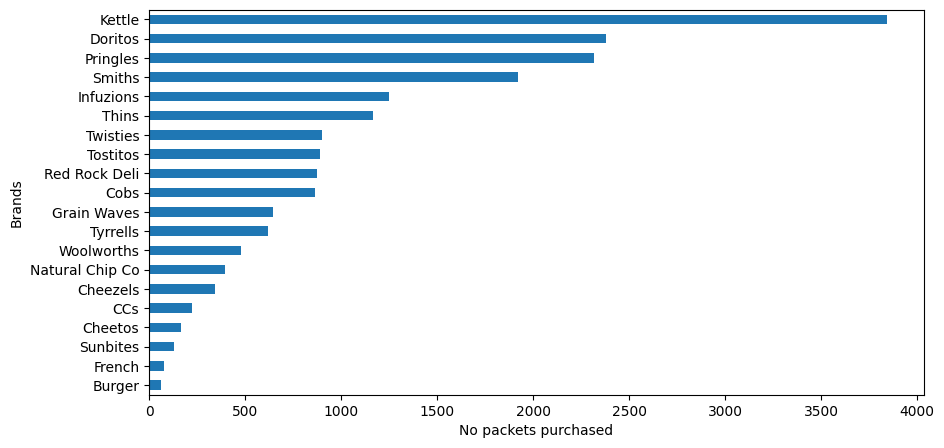

In [82]:
# Create a visual of what brands young singles/couples are purchasing the most for a general indication
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).plot.barh(figsize=(10, 5))
ax.set_xlabel("No packets purchased")
ax.set_ylabel("Brands")
plt.show()

In [83]:
temp = full_df.copy()
temp["group"] = temp["LIFESTAGE"] + ' - ' + temp['MEMBER_TYPE']

In [84]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["BRAND_NAME"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,Natural Chip Co,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
246736,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
246737,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
246738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [85]:
freq_groupsbrands = apriori(groups_brands, min_support=0.008, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)

In [86]:
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
41,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,0.002325,1.036537,0.162062
0,(MIDAGE SINGLES/COUPLES - Mainstream),(Kettle),0.044966,0.167334,0.008657,0.192519,1.150508,0.001132,1.031190,0.136978
22,(RETIREES - Budget),(Kettle),0.057652,0.167334,0.010505,0.182214,1.088926,0.000858,1.018196,0.086660
32,(RETIREES - Premium),(Kettle),0.049591,0.167334,0.008981,0.181105,1.082296,0.000683,1.016816,0.080006
12,(OLDER SINGLES/COUPLES - Budget),(Kettle),0.069596,0.167334,0.012422,0.178488,1.066658,0.000776,1.013578,0.067167
20,(OLDER SINGLES/COUPLES - Premium),(Kettle),0.067115,0.167334,0.011944,0.177959,1.063495,0.000713,1.012925,0.064000
26,(RETIREES - Mainstream),(Kettle),0.080935,0.167334,0.013723,0.169554,1.013269,0.000180,1.002674,0.014248
16,(OLDER SINGLES/COUPLES - Mainstream),(Kettle),0.069146,0.167334,0.011490,0.166168,0.993034,-0.000081,0.998602,-0.007479
34,(YOUNG FAMILIES - Budget),(Kettle),0.071991,0.167334,0.011117,0.154422,0.922837,-0.000930,0.984730,-0.082654
5,(OLDER FAMILIES - Budget),(Kettle),0.087193,0.167334,0.013455,0.154318,0.922216,-0.001135,0.984609,-0.084586


In [87]:
rules[rules['antecedents'] == {'YOUNG SINGLES/COUPLES - Mainstream'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
41,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,0.002325,1.036537,0.162062
39,(YOUNG SINGLES/COUPLES - Mainstream),(Doritos),0.079209,0.102229,0.009642,0.121725,1.190712,0.001544,1.022198,0.173944
43,(YOUNG SINGLES/COUPLES - Mainstream),(Pringles),0.079209,0.101735,0.009382,0.118451,1.164310,0.001324,1.018962,0.153262


In [88]:
# find the target rating proportion
target_segment = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
not_young_mainstream = full_df.loc[full_df['LIFESTAGE'] != "YOUNG SINGLES/COUPLES"]
not_young_mainstream = not_young_mainstream.loc[not_young_mainstream['MEMBER_TYPE'] != "Mainstream"]
other = not_young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('BRANDS').join(other.set_index('BRANDS'))
# full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,BRANDS,target,other,affinity
8,Tyrrells,0.017088,0.013368,1.278270
13,Twisties,0.024845,0.019632,1.265496
18,Doritos,0.065673,0.052511,1.250646
12,Tostitos,0.024569,0.019944,1.231911
19,Kettle,0.106115,0.086574,1.225712
17,Pringles,0.063906,0.052477,1.217793
10,Cobs,0.023851,0.020004,1.192293
15,Infuzions,0.034507,0.029930,1.152890
9,Grain Waves,0.017833,0.016214,1.099878
14,Thins,0.032188,0.029771,1.081172


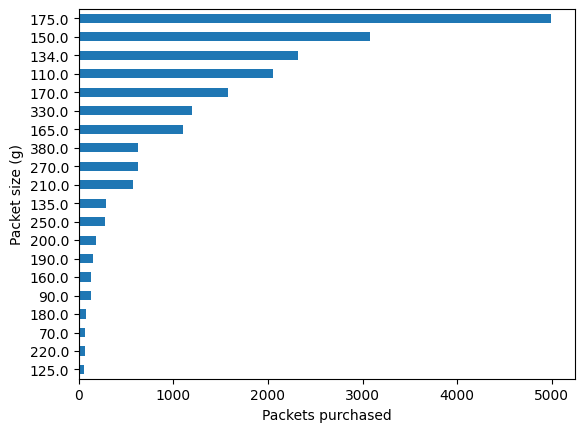

In [89]:
# Plot the distribution of the packet sizes for a general indication of what it most popular. 
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).plot.barh()
ax.set_ylabel("Packet size (g)")
ax.set_xlabel("Packets purchased")
plt.show()

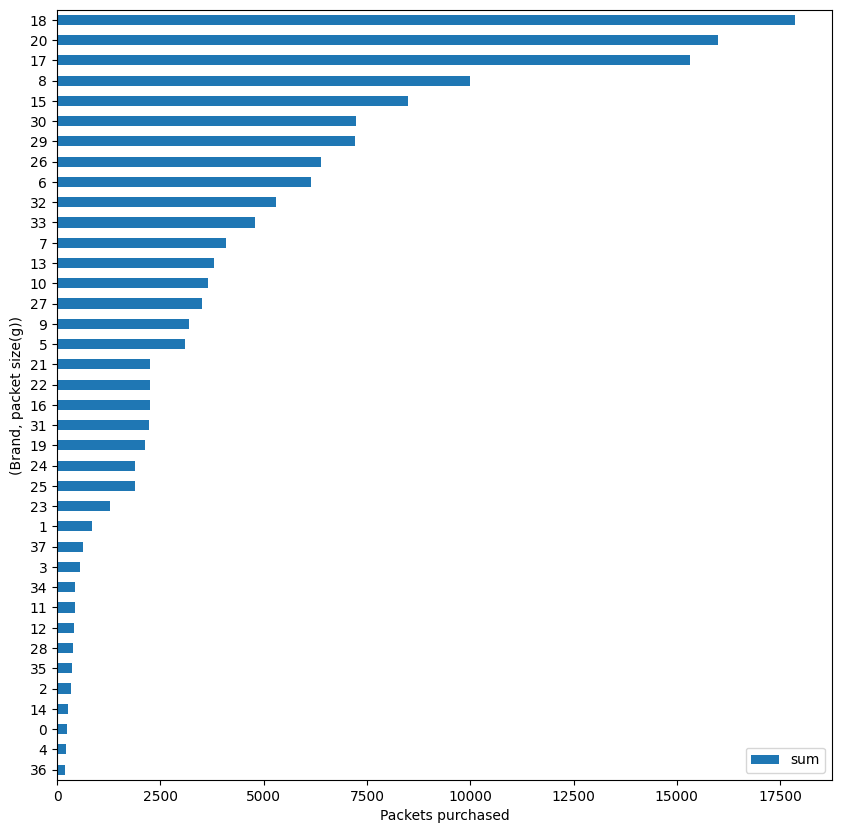

In [90]:
# Also want to check which brands correspond to what sized packets. 
brand_size = young_mainstream.groupby(['BRAND_NAME','PACK_SIZE'], as_index = False)['TOT_SALES'].agg(['sum'])
ax = brand_size.sort_values(by = 'sum').plot.barh(y = "sum", figsize=(10,10))
ax.set_ylabel("(Brand, packet size(g))")
ax.set_xlabel("Packets purchased")
plt.show()

In [91]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["PACK_SIZE"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,175.0,180.0,190.0,200.0,210.0,220.0,250.0,270.0,330.0,380.0
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246736,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
246737,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [92]:
freq_groupsbrands = apriori(groups_brands, min_support=0.009, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
38,(YOUNG FAMILIES - Premium),(175.0),0.043706,0.269069,0.012150,0.278004,1.033210,0.000391,1.012377,0.033612
34,(YOUNG FAMILIES - Budget),(175.0),0.071991,0.269069,0.019944,0.277037,1.029613,0.000574,1.011021,0.030992
40,(YOUNG SINGLES/COUPLES - Budget),(175.0),0.034745,0.269069,0.009476,0.272717,1.013558,0.000127,1.005016,0.013858
6,(OLDER FAMILIES - Mainstream),(175.0),0.053664,0.269069,0.014542,0.270977,1.007091,0.000102,1.002617,0.007440
8,(OLDER FAMILIES - Premium),(175.0),0.042162,0.269069,0.011413,0.270691,1.006030,0.000068,1.002225,0.006258
24,(RETIREES - Budget),(175.0),0.057652,0.269069,0.015591,0.270439,1.005094,0.000079,1.001879,0.005379
30,(RETIREES - Premium),(175.0),0.049591,0.269069,0.013399,0.270186,1.004154,0.000055,1.001531,0.004353
5,(OLDER FAMILIES - Budget),(175.0),0.087193,0.269069,0.023539,0.269964,1.003327,0.000078,1.001226,0.003632
12,(OLDER SINGLES/COUPLES - Budget),(175.0),0.069596,0.269069,0.018744,0.269334,1.000985,0.000018,1.000363,0.001058
20,(OLDER SINGLES/COUPLES - Premium),(175.0),0.067115,0.269069,0.018068,0.269203,1.000499,0.000009,1.000184,0.000535


In [93]:
# find the target rating proportion
target_segment = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
other = not_young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('SIZES').join(other.set_index('SIZES'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,SIZES,target,other,affinity
11,270.0,0.017115,0.012958,1.320826
12,380.0,0.017281,0.013375,1.291992
14,330.0,0.032988,0.026455,1.246968
10,210.0,0.015901,0.012973,1.225655
17,134.0,0.063906,0.052477,1.217793
16,110.0,0.056618,0.046653,1.213618
9,135.0,0.008006,0.006750,1.185951
8,250.0,0.007729,0.006674,1.158076
15,170.0,0.043478,0.041826,1.039502
18,150.0,0.085024,0.084969,1.000652


## Summary of Insights

The three highest contributing segments to the total sales are:
1. Older families - Budget
2. Young singles/couples - Mainstream
3. Retirees - Mainstream

The largest population group is mainstream young singles/couples, followed by mainstream retirees which explains their large total sales. While population is not a driving factor for budget older families, older families and young families in general buy more chips per customer. Furthermore, mainstream young singles/couples have the highest spend per purchase, which is statistically significant compared to the non-mainstream young singles/couples. Taking a further look at the mainstream yong singles/couples segment, we have found that they are 28% more likely to purchase Tyrells chips than the other segments. This segment does purchase the most Kettles chips, which is also consistent with most other segments. However, they are 50% less likely to purchase Burger Rings, which was also evident in the preferences for packet sizes given they are the only chips that come in 220g sizes. Mainstream young singles/couples are 32% more likely to purchase 270g chips, which is the size that Twisties come in, compare to the other segments. The packet size purchased most over many segments is 175g. 

Perhaps we can use the fact that Tyrells and (the packet size of) Twisties chips are more likely to be purchased by mainstream young singles/couples and place these products where they are more likely to be seen by this segment. Furthermore, given that Kettles chips are still the most popular, if the primary target segment are mainstream young singles/couples, Tyrells and Twisties could be placed closer to the Kettles chips. This strategy, with the brands they are more likely to purchase, could also be applied to other segments that purchase the most of Kettles to increase their total sales. 